# 1) Gerekli Kütüphaneler + Ortam Ayarları

Bu bölümde proje boyunca kullanacağımız tüm kütüphaneleri import ediyoruz.

* NumPy & Pandas **=>**  veri işleme ve sayısal hesaplamalar için
* Matplotlib & Seaborn & Plotly **=>** görselleştirme için
* TensorFlow / Keras **=>** CNN modelimizi kurmak, eğitmek ve değerlendirmek için
* Scikit-learn **=>** performans metrikleri (confusion matrix, classification report) için

Ayrıca:
* Seed değerleri sabitlenerek deneylerin tekrar edilebilir olması sağlandı.
* Kullanılabilir GPU olup olmadığı kontrol edildi.
* TensorFlow’dan gelen gereksiz uyarılar kapatıldı.

In [1]:
import os, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 
logging.getLogger("tensorflow").setLevel(logging.FATAL)
import random, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices('GPU'))

E0000 00:00:1758890294.054919      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758890294.110404      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2) Veri Ön İşleme + Data Augmentation + Train/Val/Test Ayrımı

Bu bölümde veri seti hazırlanıyor. Intel Image Classification veri seti 6 sınıf içeriyor:
* Buildings, Forest, Glacier, Mountain, Sea, Street

Yapılan işlemler:
* Görsellerin boyutu 128x128 piksele indirildi.
* Dataset, **Train / Validation / Test** setlerine ayrıldı. (Validation oranı: %20)
* Dataset Train (%80) – Validation (%20) – Test olarak ayrıldı.

Data Augmentation uygulandı:
1. Çevirme (flip)
2. Döndürme (rotation)
3. Yakınlaştırma/uzaklaştırma (zoom)
4. Kontrast ve parlaklık değişiklikleri

Böylece modelin overfitting riski azalırken, genelleme gücü arttırılmış oldu.
Ek olarak, veri kontrolü için örnek 6 görsel ekrana bastırıldı.

I0000 00:00:1758890305.613510      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


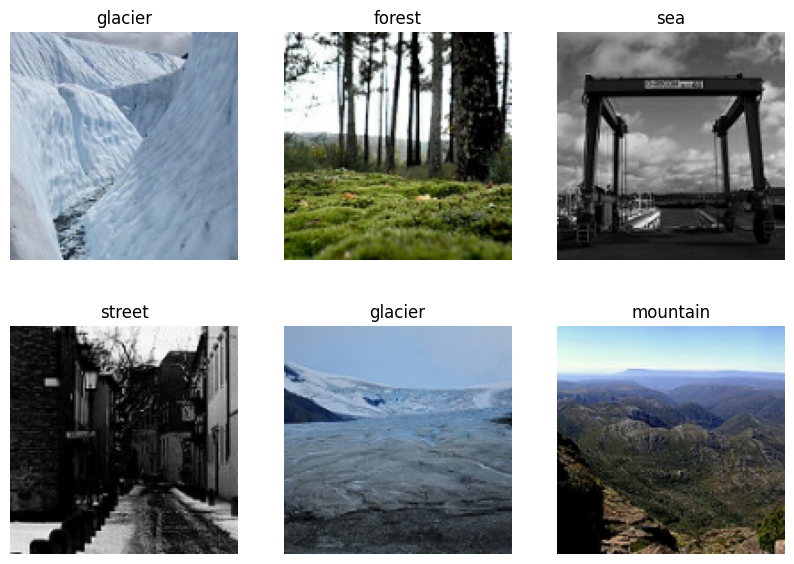

In [2]:
# Dataset dizinleri
DATASET_DIR = Path("/kaggle/input/intel-image-classification")
TRAIN_DIR   = DATASET_DIR / "seg_train" / "seg_train"
TEST_DIR    = DATASET_DIR / "seg_test" / "seg_test"

# Parametreler
IMG_SIZE   = (128,128)
BATCH_SIZE = 32
VAL_SPLIT  = 0.2
SEED       = 42

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2)
])

def make_datasets(batch_size=32):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=VAL_SPLIT,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=batch_size
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=VAL_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=batch_size
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=False
    )
    return train_ds, val_ds, test_ds, train_ds.class_names

# Default batch size ile datasetleri alıyoruz
train_ds, val_ds, test_ds, class_names = make_datasets(BATCH_SIZE)

# Sınıf isimlerini yazdırıyoruz
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Sınıflar:", class_names)

# İlk batch'ten 6 örnek göster
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):   
    for i in range(6):                    
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# 3) CNN Modeli (Conv + Pooling + Dropout + Dense + ReLU/Softmax)

Bu bölümde CNN tabanlı sınıflandırma modelimiz oluşturuldu. Modelin bileşenleri:
* Conv2D Katmanları → Görsellerden öznitelik çıkartır.
* MaxPooling Katmanları → Özellik haritasını küçültüp önemli bilgiyi korur.
* Flatten Katmanı → 2D özellik haritalarını 1D vektöre çevirir.
* Dense (Tam Bağlı) Katman → Öğrenilen özelliklerden karar verir.
* Dropout Katmanı → Overfitting’i azaltmak için bazı nöronları rastgele kapatır.
* Çıkış Katmanı (Softmax) → 6 sınıf için olasılık hesaplar.

Optimizer seçenekleri (Adam, RMSProp, SGD) denenebilir.

Loss fonksiyonu: **Sparse Categorical Crossentropy**

Değerlendirme metriği: **Accuracy**

In [3]:
# Model kurucu
def build_cnn(conv_filters=(32,64,128),
              kernel_size=(3,3),
              dense_units=128,
              dropout_rate=0.5,
              optimizer_name="adam",
              learning_rate=1e-3,
              model_name="model"):
    inp = keras.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inp)
    x = layers.Rescaling(1/255.)(x)

    # Conv blokları (her blok: Conv2D + MaxPool)
    for f in conv_filters:
        x = layers.Conv2D(f, kernel_size, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inp, out, name=model_name)

    # Optimizer seçimi
    opt = optimizer_name.lower()
    if opt == "adam":
        optimizer = keras.optimizers.Adam(learning_rate)
    elif opt == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate)
    elif opt == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate, momentum=0.9, nesterov=True)
    else:
        optimizer = keras.optimizers.Adam(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

    model = build_cnn()
    model.summary()

# 4) Eğitim Yardımcıları (EarlyStopping + Grafik Çizimi + Değerlendirme)

Eğitim sürecini kolaylaştırmak için yardımcı fonksiyonlar yazıldı:
* train_one() => modeli eğitir, early stopping uygular, accuracy ve loss grafiklerini çizer.
* EarlyStopping => Validation accuracy 7 epoch boyunca gelişmezse eğitim durdurulur.

* evaluate_and_report() =>
1. Test seti üzerinde tahmin yapılır.
 
2. Classification report ve confusion matrix ekrana bastırılır.
  
3. Test accuracy değeri döndürülür.


Bu sayede eğitim süreci hem daha verimli hem de görselle destekli hale gelir.

In [4]:
def train_one(model, train_ds, val_ds, epochs=50, name="exp"):
    early = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
    )
    hist = model.fit(
        train_ds, validation_data=val_ds,
        epochs=epochs, callbacks=[early], verbose=1
    )
    # Tek grafik: accuracy & loss (aynı figürde iki subplot)
    fig = plt.figure(figsize=(6,7))
    ax1 = plt.subplot(2,1,1)
    ax1.plot(hist.history["accuracy"], label="Train Acc")
    ax1.plot(hist.history["val_accuracy"], label="Val Acc")
    plt.legend(['train', 'test'], loc='upper left')
    ax1.set_title(f"{name} - Accuracy"); ax1.legend()

    ax2 = plt.subplot(2,1,2)
    ax2.plot(hist.history["loss"], label="Train Loss")
    ax2.plot(hist.history["val_loss"], label="Val Loss")
    plt.legend(['train', 'test'], loc='upper left')
    ax2.set_title(f"{name} - Loss"); ax2.legend()
    plt.tight_layout()
    plt.show(block=True)
    return hist

def evaluate_and_report(model, test_ds, class_names, title_prefix=""):
    # y_true / y_pred
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    # Test accuracy
    test_acc = (np.array(y_true)==np.array(y_pred)).mean()
    return test_acc


# 5) Dört Farklı Deneme (A/B/C/D)

Modelin performansını etkileyen faktörleri görmek için farklı kombinasyonlarla 4 deneme yapılmıştır:

**Deneme 1:** Basit CNN, Adam optimizer

**Deneme 2:** Daha derin CNN (fazladan filtre), Adam optimizer

**Deneme 3:** RMSProp optimizer ile eğitim

**Deneme 4:** SGD optimizer + farklı batch size

Her deneme ayrı ayrı eğitildi, kendi grafikleri çizildi ve sonuçları kaydedildi.


 ==========  Deneme1 başlıyor  ==========
Epoch 1/50


I0000 00:00:1758890320.781529      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.3654 - loss: 1.5161 - val_accuracy: 0.5392 - val_loss: 1.1677
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4809 - loss: 1.2878 - val_accuracy: 0.6087 - val_loss: 1.0622
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5073 - loss: 1.2165 - val_accuracy: 0.6372 - val_loss: 0.9981
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5419 - loss: 1.1487 - val_accuracy: 0.6379 - val_loss: 0.9531
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5535 - loss: 1.1327 - val_accuracy: 0.6639 - val_loss: 0.9096
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5705 - loss: 1.1019 - val_accuracy: 0.6368 - val_loss: 0.9776
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5934 - loss: 1.0845 - val_accuracy: 0.6900 - val_loss: 0.8455
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5986 - loss: 1.0705 - val_accuracy: 0.70

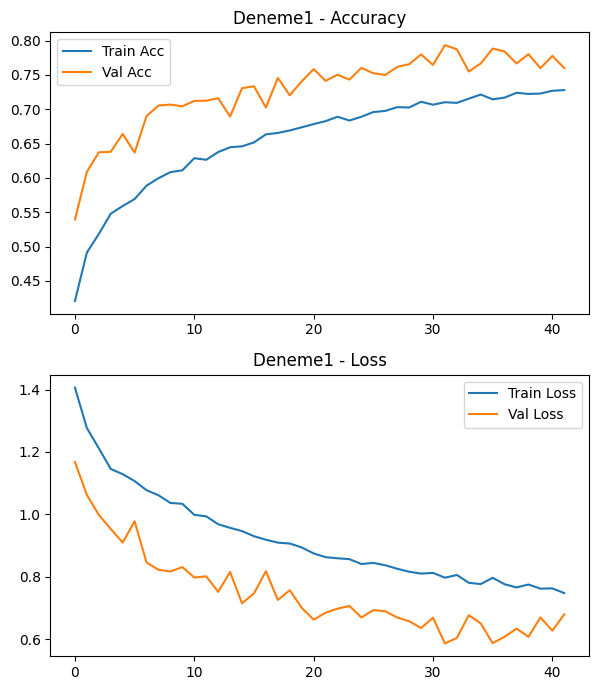


Classification Report:

              precision    recall  f1-score   support

   buildings       0.81      0.66      0.73       437
      forest       0.91      0.97      0.94       474
     glacier       0.78      0.73      0.75       553
    mountain       0.71      0.76      0.73       525
         sea       0.78      0.70      0.74       510
      street       0.75      0.88      0.81       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



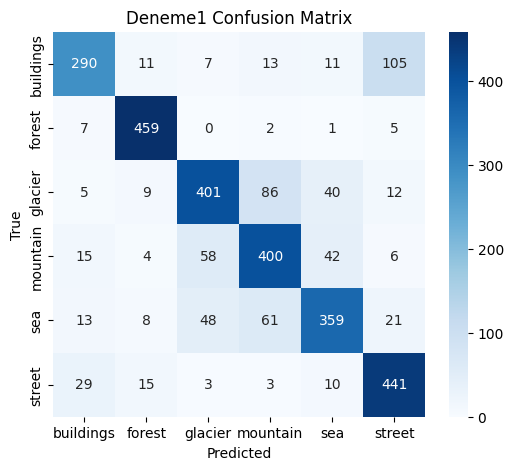

>>> Deneme1 bitti. Test Acc: 0.7833

 ==========  Deneme2 başlıyor  ==========
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3662 - loss: 1.5023 - val_accuracy: 0.5499 - val_loss: 1.1351
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5101 - loss: 1.2228 - val_accuracy: 0.6201 - val_loss: 1.0051
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5446 - loss: 1.1600 - val_accuracy: 0.6115 - val_loss: 1.0324
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5868 - loss: 1.0688 - val_accuracy: 0.6728 - val_loss: 0.8852
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6039 - loss: 1.0321 - val_accuracy: 0.6739 - val_loss: 0.8778
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6147 - loss: 1.0036 - val_accuracy: 0.6761 - val_loss: 0.8748
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6379 - loss: 0.9559 - val_accuracy: 0.7138 - val_loss: 0.7794
Epoch 8/50
351/35

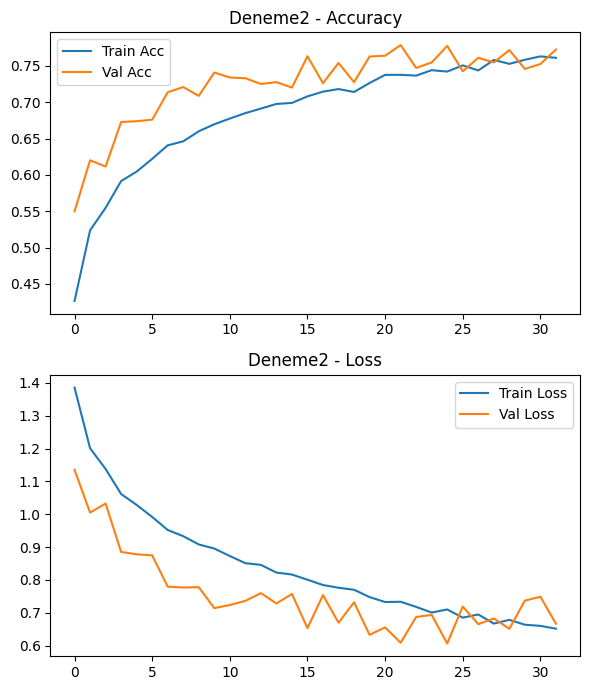


Classification Report:

              precision    recall  f1-score   support

   buildings       0.80      0.58      0.67       437
      forest       0.97      0.94      0.96       474
     glacier       0.69      0.85      0.76       553
    mountain       0.78      0.76      0.77       525
         sea       0.83      0.63      0.71       510
      street       0.72      0.91      0.80       501

    accuracy                           0.78      3000
   macro avg       0.80      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



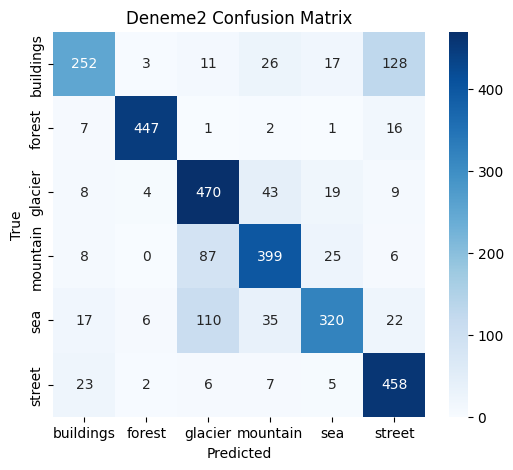

>>> Deneme2 bitti. Test Acc: 0.7820

 ==========  Deneme3 başlıyor  ==========
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.3368 - loss: 1.6201 - val_accuracy: 0.5036 - val_loss: 1.2872
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4541 - loss: 1.3311 - val_accuracy: 0.5834 - val_loss: 1.1486
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4972 - loss: 1.2562 - val_accuracy: 0.5916 - val_loss: 1.1073
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5184 - loss: 1.2182 - val_accuracy: 0.5777 - val_loss: 1.0945
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5369 - loss: 1.1875 - val_accuracy: 0.5727 - val_loss: 1.1815
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5612 - loss: 1.1464 - val_accuracy: 0.5948 - val_loss: 1.0995
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5561 - loss: 1.1325 - val_accuracy: 0.6479 - val_loss: 0.9818
Epoch 8/50


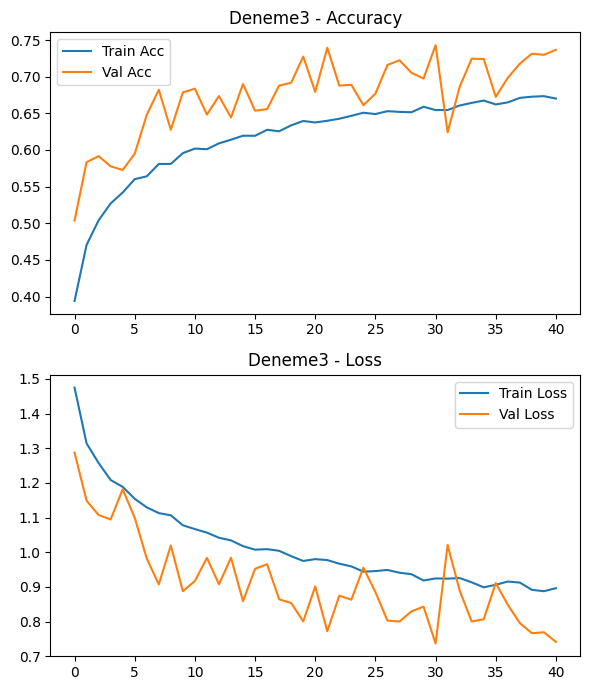


Classification Report:

              precision    recall  f1-score   support

   buildings       0.60      0.65      0.63       437
      forest       0.93      0.92      0.92       474
     glacier       0.75      0.66      0.70       553
    mountain       0.69      0.72      0.70       525
         sea       0.75      0.62      0.68       510
      street       0.68      0.82      0.74       501

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000



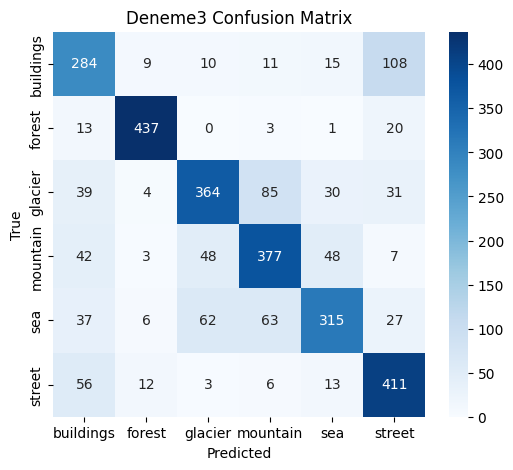

>>> Deneme3 bitti. Test Acc: 0.7293

 ==========  Deneme4 başlıyor  ==========
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.2298 - loss: 1.7531 - val_accuracy: 0.4330 - val_loss: 1.4513
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3838 - loss: 1.4960 - val_accuracy: 0.4629 - val_loss: 1.3439
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4368 - loss: 1.3929 - val_accuracy: 0.5374 - val_loss: 1.2141
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4772 - loss: 1.3152 - val_accuracy: 0.5025 - val_loss: 1.2599
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5001 - loss: 1.2669 - val_accuracy: 0.5499 - val_loss: 1.1683
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5129 - loss: 1.2305

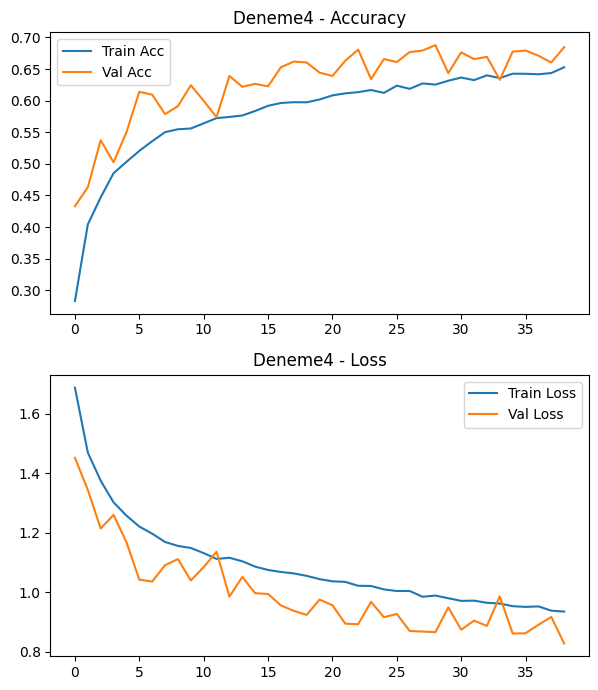


Classification Report:

              precision    recall  f1-score   support

   buildings       0.46      0.65      0.54       437
      forest       0.81      0.92      0.86       474
     glacier       0.77      0.61      0.68       553
    mountain       0.71      0.60      0.65       525
         sea       0.72      0.57      0.64       510
      street       0.67      0.75      0.71       501

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.68      3000
weighted avg       0.70      0.68      0.68      3000



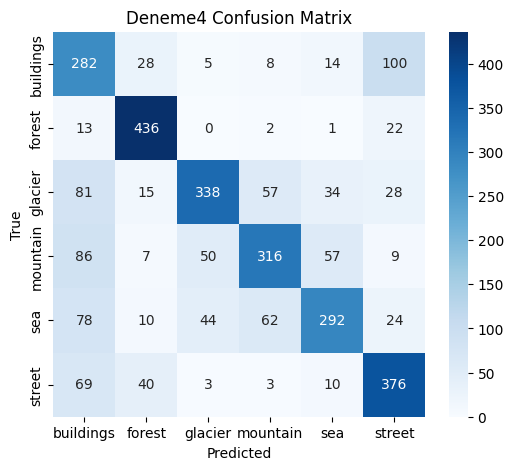

>>> Deneme4 bitti. Test Acc: 0.6800


In [5]:
# Deneme konfigleri
experiments = [
    dict(name="Deneme1",
         conv_filters=(32,64,128),
         kernel_size=(3,3),
         dense_units=128,
         dropout_rate=0.5,
         optimizer_name="adam",
         learning_rate=1e-3,
         batch_size=32),
    dict(name="Deneme2",
         conv_filters=(32,64,128,256),
         kernel_size=(3,3),
         dense_units=256,
         dropout_rate=0.3,
         optimizer_name="adam",
         learning_rate=1e-3,
         batch_size=32),
    dict(name="Deneme3",
         conv_filters=(64,128),
         kernel_size=(5,5),
         dense_units=256,
         dropout_rate=0.5,
         optimizer_name="rmsprop",
         learning_rate=1e-4,
         batch_size=32),
    dict(name="Deneme4",
         conv_filters=(32,64,128),
         kernel_size=(3,3),
         dense_units=512,
         dropout_rate=0.3,
         optimizer_name="sgd",
         learning_rate=1e-3,
         batch_size=64), 
]

results = {}  # hepsini toplayacağız (history, model, test_acc vs.)

for cfg in experiments:
    print("\n", "="*10, f" {cfg['name']} başlıyor ", "="*10)
    # batch farklı ise dataset yeniden kur
    tr, va, te, _ = (train_ds, val_ds, test_ds, class_names)
    if cfg["batch_size"] != 32:
        tr, va, te, _ = make_datasets(batch_size=cfg["batch_size"])

    model = build_cnn(conv_filters=cfg["conv_filters"],
                      kernel_size=cfg["kernel_size"],
                      dense_units=cfg["dense_units"],
                      dropout_rate=cfg["dropout_rate"],
                      optimizer_name=cfg["optimizer_name"],
                      learning_rate=cfg["learning_rate"],
                      model_name=cfg["name"])

    history = train_one(model, tr, va, epochs=50, name=cfg["name"])
    test_acc = evaluate_and_report(model, te, class_names, title_prefix=cfg["name"])

    results[cfg["name"]] = {
        "config": cfg,
        "history": history,
        "model": model,
        "test_acc": test_acc
    }
    print(f">>> {cfg['name']} bitti. Test Acc: {test_acc:.4f}")


# 6) Toplu Karşılaştırma Grafikleri (Val Accuracy + Val Loss + Test Accuracy)

Bu bölümde tüm denemelerin sonuçları karşılaştırıldı:
* Validation Accuracy Grafiği => 4 denemenin doğruluk eğrileri tek grafikte gösterildi.
* Validation Loss Grafiği => Hangi modelin daha stabil/loss bakımından daha başarılı olduğu görüldü.
* Test Accuracy Bar Grafiği => Her denemenin test seti performansı yan yana gösterildi.

Böylece hangi modelin en iyi performans verdiği görsel olarak kolayca analiz edilebildi.

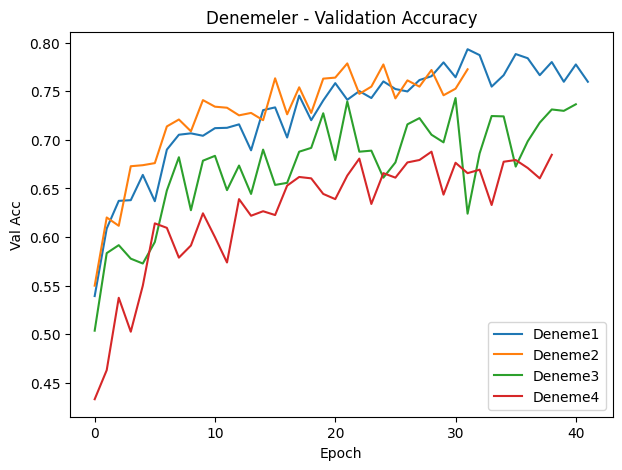

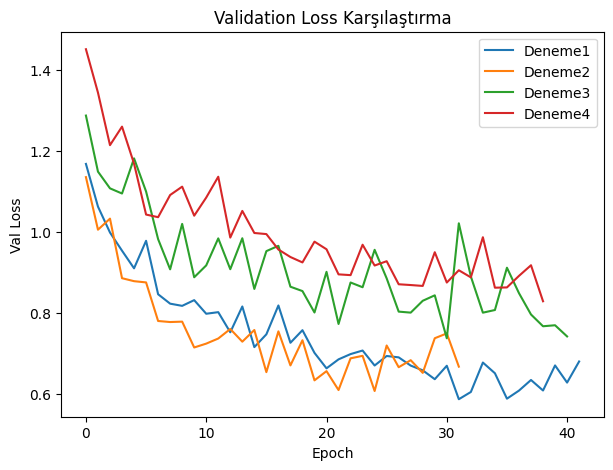

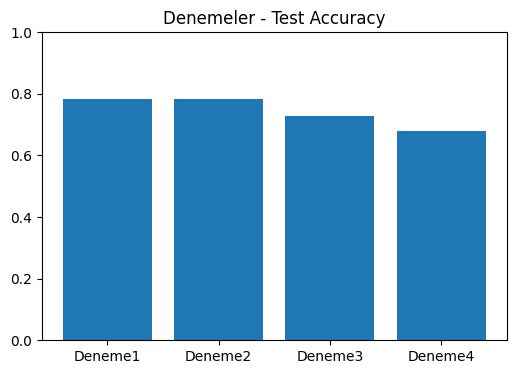

In [6]:
# Val Acc eğrileri tek grafikte
plt.figure(figsize=(7,5))
for name, info in results.items():
    va = info["history"].history["val_accuracy"]
    plt.plot(va, label=name)
plt.title("Denemeler - Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Val Acc")
plt.legend(["deneme1", "deneme2", "deneme3", "deneme4"], loc ="upper right")
plt.legend(); plt.show()

# Val Loss eğrileri tek grafikte
plt.figure(figsize=(7,5))
for name, info in results.items():
    val_loss = info["history"].history["val_loss"]
    plt.plot(val_loss, label=name)
plt.title("Validation Loss Karşılaştırma")
plt.xlabel("Epoch"); plt.ylabel("Val Loss")
plt.legend(["deneme1", "deneme2", "deneme3", "deneme4"], loc ="upper right")
plt.legend(); plt.show()

# Test Acc bar grafiği
names = list(results.keys())
scores = [results[k]["test_acc"] for k in names]
plt.figure(figsize=(6,4))
plt.bar(names, scores)
plt.ylim(0,1)
plt.title("Denemeler - Test Accuracy")
plt.show()


# 7) En İyi Model Seçimi + Detaylı Değerlendirme

Burada, test accuracy’si en yüksek olan model seçildi.
Seçilen model için:
* Eğitim sürecindeki accuracy ve loss grafikleri detaylı incelendi.
* Test setinde confusion matrix ve classification report çıkarıldı.

Bu sayede modelin güçlü/zayıf yönleri görüldü.


En iyi model: Deneme1 | Accuracy: 0.7833


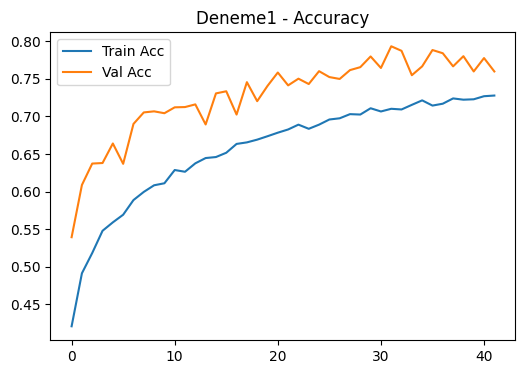

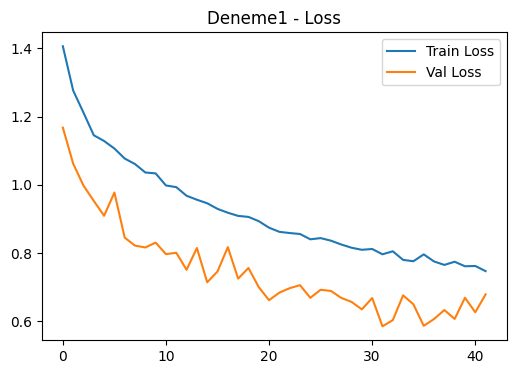

In [7]:
# En iyi test_acc hangisi?
best_name = max(results, key=lambda k: results[k]["test_acc"])
best = results[best_name]
best_model = best["model"]
best_hist  = best["history"]

print(f"\nEn iyi model: {best_name} | Accuracy: {best['test_acc']:.4f}")

# Accuracy/Loss detay (ayrı ayrı)
plt.figure(figsize=(6,4))
plt.plot(best_hist.history["accuracy"], label="Train Acc")
plt.plot(best_hist.history["val_accuracy"], label="Val Acc")
plt.title(f"{best_name} - Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(best_hist.history["loss"], label="Train Loss")
plt.plot(best_hist.history["val_loss"], label="Val Loss")
plt.title(f"{best_name} - Loss"); plt.legend(); plt.show()

# Confusion matrix + classification report zaten evaluate_and_report içinde çizildi.


# 8) Grad-CAM ile Görselleştirme

Modelin karar verirken görsellerin hangi bölgelerine odaklandığını görmek için Grad-CAM uygulandı.

Son convolution katmanı üzerinden ısı haritaları çıkarıldı.

Modelin gerçekten ilgili nesnelere odaklanıp odaklanmadığı gözlemlendi.

Bu yöntem, CNN’in “black-box” yapısını daha yorumlanabilir hale getirdi.

Son Conv2D layer: conv2d_2


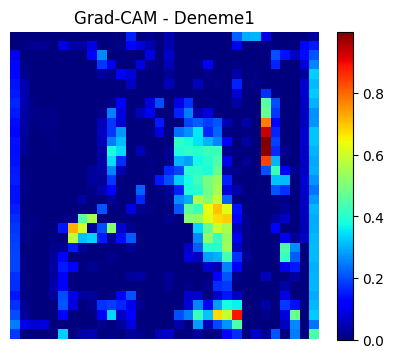

In [8]:
# Son Conv2D katmanını bul
last_conv = None
for layer in reversed(best_model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv = layer.name
        break
assert last_conv is not None, "Conv2D katmanı bulunamadı!"
print("Son Conv2D layer:", last_conv)

# Grad-CAM hesaplayıcı
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, eps=1e-8):
    grad_model = keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)             # (1,H,W,C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))           # (C,)
    conv_outputs = conv_outputs[0]                                 # (H,W,C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (H,W)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + eps)
    return heatmap.numpy()

# Test setten bir örnek al
batch_imgs, _ = next(iter(test_ds))
img = batch_imgs[0:1]  # (1,H,W,3) tensor

# Heatmap üret ve çiz
heatmap = make_gradcam_heatmap(img, best_model, last_conv)
plt.figure(figsize=(5,4))
plt.imshow(heatmap, cmap="jet"); plt.colorbar()
plt.title(f"Grad-CAM - {best_name}")
plt.axis("off"); plt.show()
